# Resturant Food Safety Inspection Prediction Using Natual Language Processing

references:
https://dev.socrata.com/foundry/data.cityofchicago.org/4ijn-s7e5

## Summary
1. [Objective](#objective)
2. [Understanding the Data](#data)\
    2.1 [Dataset Definitions](#dataset)\
    2.2 [Observations](#observations)\
    2.3 [Feature Engineering](#engineering)
4. [Model Building](#model)\
    4.1 [Model Overview](#modeloverview)
5. [Interpretation of Results](#interpretation)
6. [References](#references)



# 1. Objective
<a id='objective'></a>

The goal of this notebook is to build a multinomial classification model to predict the outcome of the food safety inspection reports based on the inspectors' comments. I will use from statistical analysis and natural language processing to accomplish this. I will also present the results of the classification model and suggest ways that it could be improved through further analysis.

Data provided by the City of Chicago via https://data.cityofchicago.org/ https://data.cityofchicago.org/Health-Human-Services/Food-Inspections/4ijn-s7e5 as of early 2020

In [356]:
import sklearn

import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import re
import itertools
import os
import random


from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, HashingVectorizer, TfidfTransformer, TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn import metrics

import nltk as nltk
import nltk.corpus  
from nltk.text import Text

import sys

pd.options.display.max_rows = 999
pd.options.display.max_colwidth = 999
pd.options.mode.chained_assignment = None  # default='warn'


<a id='data'> </a>
# 2. Understanding the Data


<a id='dataset'> </a>
## 2.1 Understanding the Data

In [357]:
#load the data
#df = pd.read_csv('../Food_Inspections.csv') #dataframe for modeling
#df_clean = df.copy() #cleaned dataframe for miscellaneous
#df_viz = df.copy() #dataframe for data viz exports for tableau


In [358]:
#!/usr/bin/env python

# make sure to install these packages before running:
# pip install pandas
# pip install sodapy

import pandas as pd
from sodapy import Socrata

# Unauthenticated client only works with public data sets. Note 'None'
# in place of application token, and no username or password:
#client = Socrata("data.cityofchicago.org", None)

# Example authenticated client (needed for non-public datasets):
MyAppToken = 'KoNWmjvpkvV18BmVoGFCU1oCw'

client = Socrata("data.cityofchicago.org",
                  MyAppToken)
#                  userame="user@example.com",
 #                 password="AFakePassword")

# First 2000 results, returned as JSON from API / converted to Python list of
# dictionaries by sodapy.
results = client.get("4ijn-s7e5", limit=250000)

# Convert to pandas DataFrame
results_df = pd.DataFrame.from_records(results)

In [359]:
results_df.shape

(211946, 22)

In [360]:
results_df.columns

Index(['inspection_id', 'dba_name', 'aka_name', 'license_', 'facility_type',
       'risk', 'address', 'city', 'state', 'zip', 'inspection_date',
       'inspection_type', 'results', 'violations', 'latitude', 'longitude',
       'location', ':@computed_region_awaf_s7ux',
       ':@computed_region_6mkv_f3dw', ':@computed_region_vrxf_vc4k',
       ':@computed_region_bdys_3d7i', ':@computed_region_43wa_7qmu'],
      dtype='object')

In [361]:
#drop extra columns from import
df = results_df.drop([':@computed_region_awaf_s7ux',
                 ':@computed_region_6mkv_f3dw',
                 ':@computed_region_vrxf_vc4k',
                 ':@computed_region_bdys_3d7i',
                 ':@computed_region_43wa_7qmu'], axis=1)

In [362]:
df.dtypes

inspection_id      object
dba_name           object
aka_name           object
license_           object
facility_type      object
risk               object
address            object
city               object
state              object
zip                object
inspection_date    object
inspection_type    object
results            object
violations         object
latitude           object
longitude          object
location           object
dtype: object

In [363]:
print(df.shape)
df.info()

(211946, 17)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 211946 entries, 0 to 211945
Data columns (total 17 columns):
inspection_id      211946 non-null object
dba_name           211946 non-null object
aka_name           209465 non-null object
license_           211929 non-null object
facility_type      207067 non-null object
risk               211874 non-null object
address            211946 non-null object
city               211792 non-null object
state              211898 non-null object
zip                211894 non-null object
inspection_date    211946 non-null object
inspection_type    211945 non-null object
results            211946 non-null object
violations         155567 non-null object
latitude           504 non-null object
longitude          504 non-null object
location           504 non-null object
dtypes: object(17)
memory usage: 27.5+ MB


In [364]:
df.isna().sum()

inspection_id           0
dba_name                0
aka_name             2481
license_               17
facility_type        4879
risk                   72
address                 0
city                  154
state                  48
zip                    52
inspection_date         0
inspection_type         1
results                 0
violations          56379
latitude           211442
longitude          211442
location           211442
dtype: int64

It appears that we have some incorrect data types and also some missing data. I'll inspect the data column by column

**inspection_id**

In [365]:
df['inspection_id'].isna().sum()

0

In [366]:
df['inspection_id'].sample(n=5)

31548     2243686
35710     2222571
184583     612304
182487     612384
103078    1561333
Name: inspection_id, dtype: object

**dba_name**

In [367]:
df['dba_name'].isna().sum()

0

In [368]:
df['dba_name'].sample(n=5)

11318         China Wok Restuarant
129549    SUBWAY SANDWICHES #22222
129475                 EPIC BURGER
141041       LAS TABLAS ON LINCOLN
140704            LADY DI'S BAKERY
Name: dba_name, dtype: object

**aka_name**

In [369]:
df['aka_name'].isna().sum()

2481

In [370]:
#sample of the missing aka_name values
df[df['aka_name'].isna()][['inspection_id','dba_name','aka_name']]

inspection_id                      dba_name aka_name
40           2453552            CLAMP DOWN BURGERS      NaN
210          2453268      CENTERS FOR NEW HORIZONS      NaN
681          2401721      BABAS STEAK AND LEMONADE      NaN
823          2401643       HEALTH FOOD & GROCERIES      NaN
884          2401495            BLUE LINE PIZZERIA      NaN
...              ...                           ...      ...
211867         80210            S L PANTRY & GRILL      NaN
211898        158243                 DUNKIN DONUTS      NaN
211904         78239                  Yahs Cuisine      NaN
211914         68250  Tots Express Learning Center      NaN
211922         78240               OBAMA FOOD MART      NaN

[2481 rows x 3 columns]

In [371]:
#fill NaN values with dba_name value
df['aka_name'] = df['aka_name'].fillna(df['dba_name'])

**license_**

In [372]:
df['license_'].isna().sum()

17

In [373]:
#Mostly churches...
df[df['license_'].isna()]['dba_name']

23345              ST. DEMETRIOS GREEK ORTHODOX CHURCH
39891              ST. DEMETRIOS GREEK ORTHODOX CHURCH
56882              ST. DEMETRIOS GREEK ORTHODOX CHURCH
82409              ST. DEMETRIOS GREEK ORTHODOX CHURCH
102320             ST. DEMETRIOS GREEK ORTHODOX CHURCH
127727             ST. DEMETRIOS GREEK ORTHODOX CHURCH
130226                                 ARGENTINA FOODS
144998             ST. DEMETRIOS GREEK ORTHODOX CHURCH
164688             ST. DEMETRIOS GREEK ORTHODOX CHURCH
168087                        OLD ST. PATRICK'S CHURCH
171412                 GOD'S BATTLE AXE PRAYER ACADEMY
171648                 GOD'S BATTLE AXE PRAYER ACADEMY
173150                 GOD'S BATTLE AXE PRAYER ACADEMY
182348             ST. DEMETRIOS GREEK ORTHODOX CHURCH
193493    AVALON COMMUNITY CHURCH/FREEDOM HOME ACADEMY
201724                             ST DEMETRIOS CHURCH
204320                        OLD ST. PATRICK'S CHURCH
Name: dba_name, dtype: object

In [374]:
#fill with "Not Disclosed"
df['license_'] = df['license_'].fillna('Not Disclosed')

**facility_type**

In [375]:
df['facility_type'].isna().sum()

4879

In [376]:
df[df['facility_type'].isna()]['dba_name'].value_counts().head(20)

SUBWAY                          34
DUNKIN DONUTS                   20
7-ELEVEN                        18
WHITE HEN PANTRY                18
HAROLD'S CHICKEN SHACK          15
TOKYO LUNCH BOXES & CATERING    13
KENTUCKY FRIED CHICKEN          12
MIDWEST BUDDHIST TEMPLE         11
MCDONALD'S                      10
MCDONALDS                        8
SCHLENKO INC.                    7
HEAVEN'S LEARNING GARDEN         7
COLD STONE CREAMERY              6
THUNDERBIRD CATERING             6
GOLD COAST DOGS                  6
CALIFORNIA FOODS                 5
QUIZNOS                          5
DEOLA'S                          5
BELEN                            5
MAN-O-SALWA                      5
Name: dba_name, dtype: int64

In [377]:
df[df['facility_type'].isna()]['dba_name'].value_counts().describe()

count    4107.000000
mean        1.187972
std         0.949387
min         1.000000
25%         1.000000
50%         1.000000
75%         1.000000
max        34.000000
Name: dba_name, dtype: float64

In [378]:
df['facility_type'].value_counts().head(15)

Restaurant                         141020
Grocery Store                       27732
School                              13074
Children's Services Facility         3567
Bakery                               3093
Daycare (2 - 6 Years)                2793
Daycare Above and Under 2 Years      2580
Long Term Care                       1426
Catering                             1277
Liquor                                928
Mobile Food Dispenser                 883
Daycare Combo 1586                    741
Mobile Food Preparer                  673
Golden Diner                          599
Hospital                              592
Name: facility_type, dtype: int64

It's not clear why so many of these facility types are missing. Some of the businesses are obvious (7-Eleven, Quiznos, for instance) but many aren't... For now, I'll fill the NA values with not disclosed


In [379]:
df['facility_type'] = df['facility_type'].fillna('Not Disclosed')

**risk**

In [380]:
df['risk'].value_counts()

Risk 1 (High)      151496
Risk 2 (Medium)     41386
Risk 3 (Low)        18961
All                    31
Name: risk, dtype: int64

In [381]:
df['risk'].isna().sum()

72

In [382]:
df[df['risk'].isna()].sample(n=5, random_state=512)

inspection_id                       dba_name  \
64982        2009375  CHICAGO BEST DELI GROCERY,INC   
181005        537572                        unknown   
34883        2229372                 RICE THAI CAFE   
196539        428391                      BEST SUBS   
25275        2286042                 REIS AND IRVYS   

                             aka_name license_  facility_type risk  \
64982   CHICAGO BEST DELI GROCERY,INC  2512074  Not Disclosed  NaN   
181005                        unknown        0  Not Disclosed  NaN   
34883                  RICE THAI CAFE  2589016  Not Disclosed  NaN   
196539                      BEST SUBS        0  Not Disclosed  NaN   
25275                  REIS AND IRVYS  2659028  Not Disclosed  NaN   

                          address     city state    zip  \
64982           156-158 W 95TH ST  CHICAGO    IL  60628   
181005      10222 S wentworth AVE  CHICAGO    IL  60628   
34883       211`7 W FARRAGUT AVE   CHICAGO    IL  60625   
196539  2653 N WASTENAW AVE BLDG   CHICAGO    IL  60647   
25275         1801 W JACKSON BLVD  CHICAGO    IL  60612   

                inspection_date inspection_type               results  \
64982   2017-03-28T00:00:00.000         License             Not Ready   
181005  2011-09-07T00:00:00.000  Complaint-Fire  Business Not Located   
34883   2018-10-04T00:00:00.000         License  Business Not Located   
196539  2010-10-29T00:00:00.000       Complaint  Business Not Located   
25275   2019-04-30T00:00:00.000         License             Not Ready   

       violations latitude longitude location  
64982         NaN      NaN       NaN      NaN  
181005        NaN      NaN       NaN      NaN  
34883         NaN      NaN       NaN      NaN  
196539        NaN      NaN       NaN      NaN  
25275         NaN      NaN       NaN      NaN

Notice that many of the missing risk values are records that were also missing other attributes...


In [383]:
#I'll fill missing risk values with not disclosed
df['risk'] = df['risk'].fillna('Not Disclosed')

**address**

In [384]:
df['address'].isna().sum()

0

In [385]:
df['address'].value_counts().head(10)

11601 W TOUHY AVE             2674
5700 S CICERO AVE              583
500 W MADISON ST               462
2300 S THROOP ST               405
324 N LEAVITT ST               391
131 N CLINTON ST               353
100 W RANDOLPH ST              331
222 W MERCHANDISE MART PLZ     279
600 E GRAND AVE                276
7601 S CICERO AVE              267
Name: address, dtype: int64

Some of these make sense:

* 5700 S CICERO AVE = Chicago Midway
* 500 W MADISON ST = Accenture Tower


**city**

In [386]:
df['city'].isna().sum()

154

In [387]:
df['city'] = df['city'].fillna('Not Disclosed')

In [388]:
df['city'].value_counts().head(20)

CHICAGO              211061
Chicago                 340
Not Disclosed           154
chicago                 108
CCHICAGO                 48
SCHAUMBURG               27
MAYWOOD                  15
CHicago                  13
ELK GROVE VILLAGE        13
EVANSTON                 11
CHICAGOCHICAGO            9
CICERO                    9
INACTIVE                  8
SKOKIE                    8
NILES NILES               7
ELMHURST                  7
CALUMET CITY              6
CHCHICAGO                 6
OAK PARK                  5
WORTH                     5
Name: city, dtype: int64

May have to do some cleaning on this column. Looks like there are considerable typos. Possibly use zip code to pull city name?

**state**

In [389]:
df['state'].isna().sum()

48

In [390]:
df[df['state'].isna()][['dba_name','city','state']].head(10)

dba_name           city state
5548        CRATER FOOD & LIQUOR        CHICAGO   NaN
6060         YOLK - LINCOLN PARK        CHICAGO   NaN
6139        CRATER FOOD & LIQUOR        CHICAGO   NaN
6162      Starbucks Coffee#51211  Not Disclosed   NaN
6612                   STAX CAFE        CHICAGO   NaN
7043                    WINGSTOP        CHICAGO   NaN
19088  AMY BECK CAKE DESIGN, LLC  Not Disclosed   NaN
23114                  STAX CAFE        CHICAGO   NaN
23534             CITY HALL. LLC        CHICAGO   NaN
23551             CITY HALL. LLC        CHICAGO   NaN

It appears there is a data input problem. For now, I'll manually fill CHICAGO values


In [392]:
df.loc[(df.city=='CHICAGO')&(df.state.isna()),'state'] = 'IL'

In [394]:
df['state'] = df['state'].fillna('Not Disclosed')

In [395]:
df['state'].value_counts()

IL               211923
Not Disclosed        20
IN                    1
NY                    1
WI                    1
Name: state, dtype: int64

Not sure why there are some other states in this dataset. For now, I'll drop other states.

In [402]:
index_list = df[df.state != 'IL'].index.to_list()

df = df.drop(index_list)

**zip**

In [405]:
df['zip'].isna().sum()

52

There are only 52 observations with missing zip values so I'll drop these values


In [407]:
df = df.dropna(subset=['zip'])

**inspection_date**

In [408]:
df['inspection_date'].isna().sum()

0

In [415]:
print(df['inspection_date'][5])
type(df['inspection_date'].iloc[5])

2020-10-22T00:00:00.000


str

I'll need to conver the inspection date column to datetime

In [412]:
#Convert inspection_date column
df['inspection_date_new'] = df['inspection_date'].apply(lambda x: datetime.strptime(x, '%Y-%m-%dT%H:%M:%S.%f'))


In [420]:
df.iloc[0]['inspection_date_new'].strftime(format='%x')

'10/23/20'

In [416]:
print(df['inspection_date_new'][5])
type(df['inspection_date_new'].iloc[5])


2020-10-22 00:00:00


pandas._libs.tslibs.timestamps.Timestamp

In [422]:
df['inspection_date_new'] = df['inspection_date_new'].apply(lambda x: x.strftime(format='%x'))

In [423]:
print(df['inspection_date_new'][5])
type(df['inspection_date_new'].iloc[5])

10/22/20


str

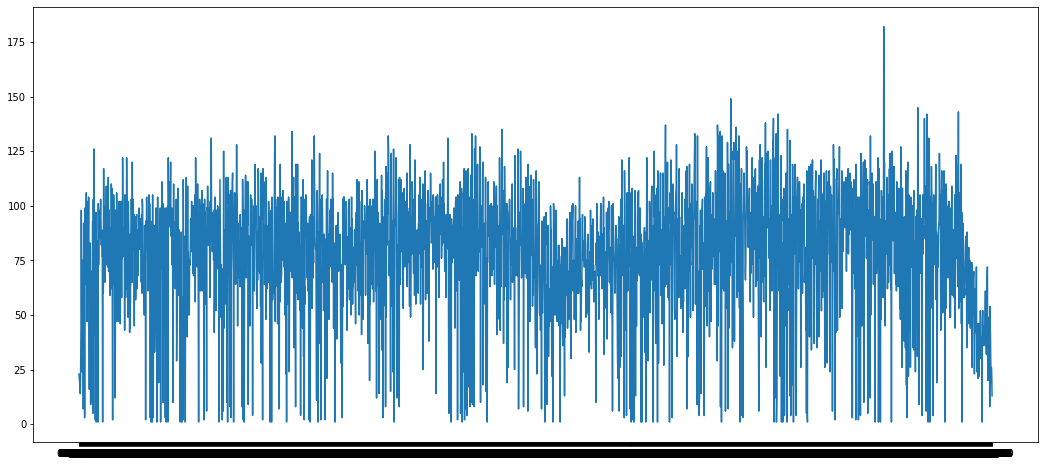

In [424]:
import matplotlib.pylab as plt
from collections import Counter

# Tally occurrences of words in a list
cnt = Counter()
for day in df['inspection_date_new']:
    cnt[day] += 1


lists = sorted(cnt.items()) # sorted by key, return a list of tuples
x, y = zip(*lists) # unpack a list of pairs into two tuples

plt.figure(figsize=(18,8))
plt.plot(x, y)

plt.show()


**inspection_type**


In [426]:
df['inspection_type'].isna().sum()


1

In [430]:
df = df.dropna(subset=['inspection_type'])


In [432]:
df['inspection_type'].value_counts().head(15)


Canvass                                   112744
License                                    27792
Canvass Re-Inspection                      22522
Complaint                                  19602
License Re-Inspection                       9466
Complaint Re-Inspection                     8090
Short Form Complaint                        7134
Suspected Food Poisoning                     874
Consultation                                 672
License-Task Force                           604
Tag Removal                                  603
Recent Inspection                            357
Out of Business                              284
Task Force Liquor 1475                       252
Suspected Food Poisoning Re-inspection       193
Name: inspection_type, dtype: int64

**results**


In [439]:
pd.DataFrame({'counts':df['results'].value_counts(),
              'percentage':df['results'].value_counts()/df.shape[0]})

counts  percentage
Pass                  111230    0.524992
Fail                   40951    0.193284
Pass w/ Conditions     31990    0.150989
Out of Business        18377    0.086737
No Entry                7055    0.033299
Not Ready               2197    0.010370
Business Not Located      70    0.000330

I'm building a classification model to predict the multinomial classifications above based on the inspector's comments. Therefore, I plan to exclude the four results that we do not have sufficient records. Separately, I also noticed some records for "no entry" still had comments associated with them. 

In [442]:
df[df['results']=='No Entry']

inspection_id                  dba_name                   aka_name  \
18           2453650        STUDIO MOVIE GRILL         STUDIO MOVIE GRILL   
19           2453659             WALMART #5781              WALMART #5781   
26           2453641  SANJUSTIN'S KITCHEN INC.        SANJUSTIN'S KITCHEN   
40           2453552        CLAMP DOWN BURGERS         CLAMP DOWN BURGERS   
74           2453489    LA FUENTE BANQUET HALL     LA FUENTE BANQUET HALL   
...              ...                       ...                        ...   
167307       1230048         TAPAS LAS RAMBLAS          TAPAS LAS RAMBLAS   
167669       1229215      CHICAGO FONDUE STUBE       CHICAGO FONDUE STUBE   
167721       1229216   KATSU ENTERPRISESES INC  KATSU JAPANESE RESTAURANT   
172274        671042             MAGNOLIA CAFE              MAGNOLIA CAFE   
172979        588252     GARRETT POPCORN SHOPS      GARRETT POPCORN SHOPS   

       license_  facility_type             risk               address  \
18      2309244     Restaurant    Risk 1 (High)         210 W 87TH ST   
19      2104019  Grocery Store    Risk 1 (High)    8331 S STEWART AVE   
26      2418532       Catering    Risk 1 (High)         157 W 75th ST   
40      2749943  Not Disclosed  Risk 2 (Medium)    1742 W DIVISION ST   
74      1841170     Restaurant    Risk 1 (High)        2514 W 51ST ST   
...         ...            ...              ...                   ...   
167307  1799141     Restaurant    Risk 1 (High)  5101-5103 N CLARK ST   
167669    26813     Restaurant    Risk 1 (High)   2717 W PETERSON AVE   
167721    16281     Restaurant    Risk 1 (High)   2651 W PETERSON AVE   
172274  1968899     Restaurant    Risk 1 (High)     1224 W WILSON AVE   
172979  2125326     Restaurant  Risk 2 (Medium)     27 W JACKSON BLVD   

           city state    zip          inspection_date inspection_type  \
18      CHICAGO    IL  60620  2020-10-21T00:00:00.000         Canvass   
19      CHICAGO    IL  60620  2020-10-21T00:00:00.000         Canvass   
26      CHICAGO    IL  60620  2020-10-21T00:00:00.000         Canvass   
40      CHICAGO    IL  60622  2020-10-20T00:00:00.000         License   
74      CHICAGO    IL  60632  2020-10-19T00:00:00.000         Canvass   
...         ...   ...    ...                      ...             ...   
167307  CHICAGO    IL  60640  2012-06-05T00:00:00.000       Complaint   
167669  CHICAGO    IL  60659  2012-05-29T00:00:00.000         Canvass   
167721  CHICAGO    IL  60659  2012-05-29T00:00:00.000         Canvass   
172274  CHICAGO    IL  60640  2012-03-01T00:00:00.000         Canvass   
172979  CHICAGO    IL  60604  2012-02-14T00:00:00.000       Complaint   

         results  \
18      No Entry   
19      No Entry   
26      No Entry   
40      No Entry   
74      No Entry   
...          ...   
167307  No Entry   
167669  No Entry   
167721  No Entry   
172274  No Entry   
172979  No Entry   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          violations  \
18      55. PHYSICAL FACILITIES INSTALLED, MAINTAINED & CLEAN - Comments: Violation Codes: 6-501.11 Inspector Comments: DAMAGED FLOOR TILE AROUND THE FLOOR DRAIN BEHIND THE CONCESSION STAND. INSTRUCTED TO REPAIR/REPLACE FLOOR TILE. MAINTAIN SMOOTH AND EASILY CLEANABLE FLOORS. | 58. ALLERGEN TRAINING AS REQUIRED - Comments: Violation Codes: 2-102.13 Inspector Comments: OBSERVED NO ALLERGEN TRAINING AVAILABLE DURING INSPECTION. ALL CERTIFIED MANAGERS MUST PROVIDE ALLERGEN TRAINING.   
19                                                                                                             

In [453]:
#I'm setting the threshold for data sufficiency at 15%, so if a result is not at least 15% of the dataset, it will be dropped
perc = df['results'].value_counts()/df.shape[0]
my_list = perc[perc>0.15].keys().to_list()

df = df[df.results.isin(my_list)]

**violations**


In [454]:
df.violations.isna().sum()

29225

In [457]:
df[df['violations'].isna()].sample(n=10, random_state=512)

inspection_id                                            dba_name  \
209946        176264                                          THRESHOLDS   
198194        409300                                       AMERICA'S DOG   
152981       1110304             AFCSushi@Northwestern Memorial Hospital   
177255        509422                                    SPEEDY MINI-MART   
198864        413714                          THE DOCK AT MONTROSE BEACH   
190091        569251                                          FOX & OBEL   
63323        2028787                   TRUMAN MIDDLE COLLEGE HIGH SCHOOL   
19655        2304586  ROOTS HANDMADE PIZZA - SECOND CITY/UTOPIAN TAILGAT   
103277       1560190                               GIORDANO'S RESTAURANT   
66213        1995332                                          CHINA CHEF   

                                                  aka_name license_  \
209946                                          THRESHOLDS    44305   
198194                                       AMERICA'S DOG  1798214   
152981                                           AFC Sushi  1998085   
177255                                    SPEEDY MINI-MART  1741572   
198864                          THE DOCK AT MONTROSE BEACH  2043260   
190091                                          FOX & OBEL  1893331   
63323                    TRUMAN MIDDLE COLLEGE HIGH SCHOOL  3122637   
19655   ROOTS HANDMADE PIZZA - SECOND CITY/UTOPIAN TAILGAT  2636845   
103277                               GIORDANO'S RESTAURANT  2184219   
66213                                           CHINA CHEF  2245705   

                       facility_type             risk              address  \
209946  Children's Services Facility    Risk 1 (High)   1110 W BELMONT AVE   
198194                    Restaurant    Risk 1 (High)     22 E RANDOLPH ST   
152981                    Restaurant    Risk 1 (High)       251 E HURON ST   
177255                 Grocery Store  Risk 2 (Medium)       2801 W 63RD ST   
198864                    Restaurant    Risk 1 (High)    4400 N SIMONDS DR   
190091                    Restaurant    Risk 1 (High)    401 E ILLINOIS ST   
63323                         School     Risk 3 (Low)    1145 W WILSON AVE   
19655                     Restaurant     Risk 3 (Low)      1610 N WELLS ST   
103277                    Restaurant    Risk 1 (High)  1340 S MICHIGAN AVE   
66213                     Restaurant    Risk 1 (High)   4600 W BELMONT AVE   

           city state    zip          inspection_date  \
209946  CHICAGO    IL  60657  2010-02-17T00:00:00.000   
198194  CHICAGO    IL  60601  2010-10-01T00:00:00.000   
152981  CHICAGO    IL  60611  2013-03-06T00:00:00.000   
177255  CHICAGO    IL  60629  2011-11-16T00:00:00.000   
198864  CHICAGO    IL  60640  2010-09-21T00:00:00.000   
190091  CHICAGO    IL  60611  2011-03-21T00:00:00.000   
63323   CHICAGO    IL  60640  2017-04-24T00:00:00.000   
19655   CHICAGO    IL  60614  2019-08-13T00:00:00.000   
103277  CHICAGO    IL  60605  2015-07-14T00:00:00.000   
66213   CHICAGO    IL  60641  2017-03-09T00:00:00.000   

                inspection_type results violations latitude longitude  \
209946                  License    Pass        NaN      NaN       NaN   
198194             Consultation    Pass        NaN      NaN       NaN   
152981                  Canvass    Pass        NaN      NaN       NaN   
177255  Complaint Re-Inspection    Pass        NaN      NaN       NaN   
198864                  License    Fail        NaN      NaN       NaN   
190091  Complaint Re-Inspection    Pass        NaN      NaN       NaN   
63323                   Canvass    Pass        NaN      NaN       NaN   
19655                   License    Fail        NaN      NaN       NaN   
103277                  Canvass    Pass        NaN      NaN       NaN   
66213   Complaint Re-Inspection    Pass        NaN      NaN       NaN   

       location inspection_date_new  
209946      NaN            02/17/10  
198194      NaN      

The inspector's comments are a key independent variable. Therefore, any records with missing comments have to be dropped

In [458]:
df = df.dropna(subset=['violations'])

**latitude & longitude**

In [460]:
print(df.latitude.isna().sum())
print(df.longitude.isna().sum())

154661
154661


In [461]:
df['latitude'] = df['latitude'].fillna('Not Disclosed')
df['longitude'] = df['longitude'].fillna('Not Disclosed')

**location**

In [462]:
df['location'].isna().sum()

154661

In [463]:
df['location'] = df['location'].fillna('Not Disclosed')

I want to use the address and the geopy package to pull the latitude and longitude values. But I noticed there were a lot of typos in the City list. We know that a city can have multiple zipcodes but a zipcode can only have one city.

In [484]:
#list of unique zipcodes
zipcode_list = df['zip'].unique()

#empty dictionary for for loop
my_new_dict = {}

#loop through unique zipcodes and check the length of the value counts
for z in zipcode_list:
    my_new_dict[z] = len(df[df.zip==str(z)][['city']]['city'].value_counts())
    


In [507]:
sort_zipcodes = sorted(my_new_dict.items(), key=lambda x: x[1], reverse=True)

In [515]:
sort_zipcodes[:36]

[('60649', 5),
 ('60610', 4),
 ('60638', 3),
 ('60608', 3),
 ('60659', 3),
 ('60618', 3),
 ('60647', 3),
 ('60639', 3),
 ('60606', 3),
 ('60611', 3),
 ('60612', 3),
 ('60642', 3),
 ('60625', 2),
 ('60609', 2),
 ('60644', 2),
 ('60601', 2),
 ('60619', 2),
 ('60620', 2),
 ('60641', 2),
 ('60614', 2),
 ('60634', 2),
 ('60622', 2),
 ('60632', 2),
 ('60621', 2),
 ('60629', 2),
 ('60607', 2),
 ('60646', 2),
 ('60605', 2),
 ('60616', 2),
 ('60637', 2),
 ('60666', 2),
 ('60617', 2),
 ('60707', 2),
 ('60603', 2),
 ('60153', 2),
 ('60626', 1)]

In [555]:
df[df['zip']=='60626']['city'].value_counts()

CHICAGO    2574
Name: city, dtype: int64

In [556]:
df.loc[(df['zip']=='60649'), 'city'] = 'CHICAGO'
df.loc[(df['zip']=='60610'), 'city'] = 'CHICAGO'
df.loc[(df['zip']=='60638'), 'city'] = 'CHICAGO'
df.loc[(df['zip']=='60608'), 'city'] = 'CHICAGO'
df.loc[(df['zip']=='60659'), 'city'] = 'CHICAGO'
df.loc[(df['zip']=='60618'), 'city'] = 'CHICAGO'
df.loc[(df['zip']=='60647'), 'city'] = 'CHICAGO'
df.loc[(df['zip']=='60639'), 'city'] = 'CHICAGO'
df.loc[(df['zip']=='60606'), 'city'] = 'CHICAGO'
df.loc[(df['zip']=='60611'), 'city'] = 'CHICAGO'
df.loc[(df['zip']=='60612'), 'city'] = 'CHICAGO'
df.loc[(df['zip']=='60642'), 'city'] = 'CHICAGO'
df.loc[(df['zip']=='60625'), 'city'] = 'CHICAGO'
df.loc[(df['zip']=='60609'), 'city'] = 'CHICAGO'
df.loc[(df['zip']=='60644'), 'city'] = 'CHICAGO'
df.loc[(df['zip']=='60601'), 'city'] = 'CHICAGO'
df.loc[(df['zip']=='60619'), 'city'] = 'CHICAGO'
df.loc[(df['zip']=='60620'), 'city'] = 'CHICAGO'
df.loc[(df['zip']=='60641'), 'city'] = 'CHICAGO'
df.loc[(df['zip']=='60614'), 'city'] = 'CHICAGO'
df.loc[(df['zip']=='60634'), 'city'] = 'CHICAGO'
df.loc[(df['zip']=='60622'), 'city'] = 'CHICAGO'
df.loc[(df['zip']=='60632'), 'city'] = 'CHICAGO'
df.loc[(df['zip']=='60621'), 'city'] = 'CHICAGO'
df.loc[(df['zip']=='60629'), 'city'] = 'CHICAGO'
df.loc[(df['zip']=='60607'), 'city'] = 'CHICAGO'
df.loc[(df['zip']=='60646'), 'city'] = 'CHICAGO'
df.loc[(df['zip']=='60605'), 'city'] = 'CHICAGO'
df.loc[(df['zip']=='60616'), 'city'] = 'CHICAGO'
df.loc[(df['zip']=='60637'), 'city'] = 'CHICAGO'
df.loc[(df['zip']=='60666'), 'city'] = 'CHICAGO'
df.loc[(df['zip']=='60617'), 'city'] = 'CHICAGO'
df.loc[(df['zip']=='60707'), 'city'] = 'CHICAGO'
df.loc[(df['zip']=='60603'), 'city'] = 'CHICAGO'
df.loc[(df['zip']=='60153'), 'city'] = 'MAYWOOD'



In [79]:
df.shape

(211946, 17)

In [63]:
results_df.shape

(211946, 22)

In [66]:
results_df.sample()

inspection_id                 dba_name          aka_name license_  \
142605       1324654  5 BOROUGHS PIZZA & SUBS  5 BOROUGHS PIZZA  2269618   

       facility_type             risk             address     city state  \
142605    Restaurant  Risk 2 (Medium)  1543 N Sedgwick ST  CHICAGO    IL   

          zip  ...             results  \
142605  60610  ...  Pass w/ Conditions   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                         violations  \
142605  21. * CERTIFIED FOOD MANAGER ON SITE WHEN POTENTIALLY HAZARDOUS FOODS ARE  PREPARED AND SERVED - Comments: NO CERTIFIED FOOD SERVICE MANAGER ON DUTY WHILE POTENTIALLY HAZARDOUS FOODS ARE BEING PREPARED AND SERVED SUCH AS SAUSAGE PIZZAS, GYROS AND ITALIAN BEEF. SERIOUS CITATION ISSUED #7-38-012.INSTRUCTED MANAGER TO ENROLL MORE EMPLOYEE'S IN CITY SANITATION CLASS AND HAVE PROOF ON PREMISES. | 38. VENTILATION: ROOMS AND EQUIPMENT VENTED AS REQUIRED: PLUMBING: INSTALLED AND MAINTAINED - Comments: NOTED MISSING FILTER ABOVE COOKING EQUIPMENT. MUST REPLACE AND MAINTAIN.   

       latitude longitude location :@computed_region_awaf_s7ux  \
142605      NaN       NaN      NaN                         NaN   

       :@computed_region_6mkv_f3dw :@computed_region_vrxf_vc4k  \
142605                         NaN                         NaN   

       :@computed_region_bdys_3d7i :@computed_region_43wa_7qmu  
142605                         NaN                         NaN  

[1 rows x 22 columns]

In [9]:
pd.DataFrame({'count':df.Results.value_counts(),
              'percent':df.Results.value_counts()/len(df)})

count   percent
Pass                  108721  0.529742
Fail                   39640  0.193145
Pass w/ Conditions     30183  0.147066
Out of Business        17763  0.086550
No Entry                6803  0.033148
Not Ready               2052  0.009998
Business Not Located      72  0.000351

In [46]:
df.columns

Index(['Inspection ID', 'DBA Name', 'AKA Name', 'License #', 'Facility Type',
       'Risk', 'Address', 'City', 'State', 'Zip', 'Inspection Date',
       'Inspection Type', 'Results', 'Violations', 'Latitude', 'Longitude',
       'Location'],
      dtype='object')

Shape of the dataset

In [15]:
df.shape

(205234, 17)

# Data Dictionary

**Inspection ID:** unqiue identifier

**DBA Name:** "doing businessness as"

**AKA Name:** "also known as"

**License #:** License Number identification

**Facility Type:** The type of facility. Examples include: restaurant, grocery store, school, bakery, catering, etc.

**Risk:** Risk category. Categorical value of risk 1, risk 2, risk 3, or "all".

**Address:** Number and street name. For example, 401 N WABASH AVE

**City:** Self explanatory

**State:** Self explanatory

**Zip:** Self explanatory

**Inspection Date:**

**Inspection Type:** 

**Results:** Categorical value: Pass, Fail, Pass w/ Conditions, Out of Business, No Entry, Not Ready, Business Not Located

**Violations:** String of specific code violation and inspector's comments.

**Latitude:** Self explanatory

**Longitude:** Self explanatory

**Location:** Comination of latitude and longitude columns

In [19]:
#Ten most popular facility types
df['Facility Type'].value_counts()[:10]

Restaurant                         136990
Grocery Store                       26112
School                              12751
Children's Services Facility         3358
Bakery                               2995
Daycare (2 - 6 Years)                2749
Daycare Above and Under 2 Years      2509
Long Term Care                       1421
Catering                             1249
Liquor                                886
Name: Facility Type, dtype: int64

In [16]:
df['Risk'].value_counts()

Risk 1 (High)      147513
Risk 2 (Medium)     39813
Risk 3 (Low)        17806
All                    32
Name: Risk, dtype: int64

In [18]:
#sample restaurant
df[df['Facility Type']=='Restaurant'].sample(n=1)

Inspection ID                   DBA Name                AKA Name  \
134029       1372435  TRUMP INTERNATIONAL HOTEL  BANQUETS/MEETING ROOMS   

        License # Facility Type           Risk            Address     City  \
134029  2048786.0    Restaurant  Risk 1 (High)  401 N WABASH AVE   CHICAGO   

       State    Zip Inspection Date Inspection Type Results  \
134029    IL  60611      2014-03-11         Canvass    Pass   

                                                                                                                                                                                       Violations  \
134029  32. FOOD AND NON-FOOD CONTACT SURFACES PROPERLY DESIGNED, CONSTRUCTED AND MAINTAINED - Comments: MISSING ONE SNEEZE GUARD AT EMPLOYEES CAFTERIA SELF SERVICE LINE. INSTRUCTED TO INSTALL.   

         Latitude  Longitude                                  Location  
134029  41.889284 -87.626549  (-87.62654854794113, 41.889284013529334)

Cities

In [24]:
df['City'].value_counts()[:7]

CHICAGO            204359
Chicago               328
chicago               101
CCHICAGO               48
SCHAUMBURG             27
MAYWOOD                15
CHESTNUT STREET        13
Name: City, dtype: int64

In [23]:
len(df['City'].unique())

72

Results

In [25]:
df['Results'].value_counts()

Pass                    108721
Fail                     39640
Pass w/ Conditions       30183
Out of Business          17763
No Entry                  6803
Not Ready                 2052
Business Not Located        72
Name: Results, dtype: int64

<a id='observations'></a>
### 2.1 Observations

* There are a lot of extra unneccesary columns
* We care about 'results', and 'violations'
* \>50K N/A's in violations column
* This is a multinomial classification problem. We'll narrow the classes to pass, fail, and pass w/ conditions due to data insufficency and other limitations.


In [48]:
#drop N/As
df = df.dropna(subset =['Violations'], axis=0)

#Drop Unneccesary Columns
select_cols = ['Results', 'Violations']
df = df[select_cols]

#Drop classes with insufficient data
df = df[(df.Results=='Pass')|(df.Results=='Fail')|(df.Results=='Pass w/ Conditions')]




In [49]:
df.head(2)

Results  \
0                Pass   
2  Pass w/ Conditions   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                Violations  
0                                                                                                                                                                                                                                                                                                                                                                                                                                53. TOILET FACILITIES: PROPERLY CONSTRUCTED, SUPPLIED, & CLEANED - Comments: 5-501.17  OBSERVED NO COVERED WASTE RECEPTACLE INSIDE OF THE WOMEN'S WASHROOM. MUST PROVIDE.  
2  5. PROCEDURES FOR RESPONDING TO VOMITING AND DIARRHEAL EVENTS - Comments: NO PROCEDURE IN PLACE FOR RESPONDING TO VOMITING AND DIARRHEAL EVENTS. INSTD TO PROVIDE PROCEDURE AND NECESSARY SUPPLIES EFFECTIVE AGAINST NOROVIRUS. PRIORITY FOUNDATION 7-38-005 | 36. THERMOMETERS PROVIDED & ACCURATE - Comments: MISSING FOOD TEMPERATURE MEASURING DEVICE. INSTD TO PROVIDE AND MAINTAIN SAME. PRIORITY FOUNDATION 7-38-005. | 51. PLUMBING INSTALLED; PROPER BACKFLOW DEVICES - Comments: MISSING TOILET TANK COVER. INSTD TO REPLACE AND MAINTAIN. TOILET HANDLE LOOSE. INSTD TO REPAIR AND MAINTAIN.

In [50]:
print(df.info())
print(df.describe())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 150186 entries, 0 to 205233
Data columns (total 2 columns):
Results       150186 non-null object
Violations    150186 non-null object
dtypes: object(2)
memory usage: 3.4+ MB
None
       Results  \
count   150186   
unique       3   
top       Pass   
freq     84015   

                                                                                                                                Violations  
count                                                                                                                               150186  
unique                                                                                                                              149347  
top     45. FOOD HANDLER REQUIREMENTS MET - Comments: ALL FOOD HANDLING EMPLOYEES MUST SHOW PROOF OF FOOD HANDLER TRAINING.  MUST PROVIDE.  
freq                                                                                                                

Location

<a id='engineering'></a>
## 2. Feature Engineering

* Extract only comments from violations, drop rest of text
* map Results_Flag

In [12]:
#Check sample Violation entry
df.iloc[131413]['Violations']

'2. FACILITIES TO MAINTAIN PROPER TEMPERATURE - Comments: All food establishments that display, prepare, or store potentially hazardous food shall have adequate refrigerated food storage facilities.    MUST HAVE COOLER AT 40F OR BELOW, FREEZER UNDER 0F. | 18. NO EVIDENCE OF RODENT OR INSECT OUTER OPENINGS PROTECTED/RODENT PROOFED, A WRITTEN LOG SHALL BE MAINTAINED AVAILABLE TO THE INSPECTORS - Comments: MUST PROVIDE PEST CONTROL LOG BOOK. | 33. FOOD AND NON-FOOD CONTACT EQUIPMENT UTENSILS CLEAN, FREE OF ABRASIVE DETERGENTS - Comments: All utensils shall be thoroughly cleaned and sanitized after each usage.    MUST CLEAN-SANITIZE; EQUIPMENT, SINKS, COUNTERS, ETC.. | 34. FLOORS: CONSTRUCTED PER CODE, CLEANED, GOOD REPAIR, COVING INSTALLED, DUST-LESS CLEANING METHODS USED - Comments: The floors shall be constructed per code, be smooth and easily cleaned, and be kept clean and in good repair.    MUST CLEAN FLOORS THRU-OUT PREMISES, INCLUDINT BASEMENT. | 35. WALLS, CEILINGS, ATTACHED EQUIPM

In [13]:
#regex expression to extract the text following "Comments:"
df.Violations = df.Violations.str.findall(r"(?:\sComments:\s.*?)?(?:[|]|$)")

In [14]:
#Now check sample violation
df.iloc[131413]['Violations']

[' Comments: All food establishments that display, prepare, or store potentially hazardous food shall have adequate refrigerated food storage facilities.    MUST HAVE COOLER AT 40F OR BELOW, FREEZER UNDER 0F. |',
 ' Comments: MUST PROVIDE PEST CONTROL LOG BOOK. |',
 ' Comments: All utensils shall be thoroughly cleaned and sanitized after each usage.    MUST CLEAN-SANITIZE; EQUIPMENT, SINKS, COUNTERS, ETC.. |',
 ' Comments: The floors shall be constructed per code, be smooth and easily cleaned, and be kept clean and in good repair.    MUST CLEAN FLOORS THRU-OUT PREMISES, INCLUDINT BASEMENT. |',
 ' Comments: The walls and ceilings shall be in good repair and easily cleaned.    MUST SEAL RAW WOOD DOOR FRAME FOR MOP CLOSET. |',
 ' Comments: Ventilation: All plumbing fixtures, such as toilets, sinks, washbasins, etc., must be adequately trapped, vented, and re-vented and properly connected to the sewer in accordance with the plumbing chapter of the Municipal Code of Chicago and the Rules an

In [15]:
#Lemmatize Violations
w_tokenizer = nltk.tokenize.WhitespaceTokenizer()
lemmatizer = nltk.stem.WordNetLemmatizer()

def lemmatize_text(text):
    return [lemmatizer.lemmatize(w) for w in w_tokenizer.tokenize(text)]

df.Violations = df.Violations.str.join(' ')

#remove "Comments"
df['Violations'] = df['Violations'].str.replace('Comments*\s','')
df['Violations'] = df['Violations'].str.replace('Comments','')

#Remove Punctuation
df['Violations'] = df['Violations'].str.replace('[^\w\s]','')

#Remove non-alphanumeric
df['Violations'] = df['Violations'].str.replace('[^\D\s]','')


In [16]:
#Now check sample violation
df.iloc[131413]['Violations']

'  All food establishments that display prepare or store potentially hazardous food shall have adequate refrigerated food storage facilities    MUST HAVE COOLER AT F OR BELOW FREEZER UNDER F    MUST PROVIDE PEST CONTROL LOG BOOK    All utensils shall be thoroughly cleaned and sanitized after each usage    MUST CLEANSANITIZE EQUIPMENT SINKS COUNTERS ETC    The floors shall be constructed per code be smooth and easily cleaned and be kept clean and in good repair    MUST CLEAN FLOORS THRUOUT PREMISES INCLUDINT BASEMENT    The walls and ceilings shall be in good repair and easily cleaned    MUST SEAL RAW WOOD DOOR FRAME FOR MOP CLOSET    Ventilation All plumbing fixtures such as toilets sinks washbasins etc must be adequately trapped vented and revented and properly connected to the sewer in accordance with the plumbing chapter of the Municipal Code of Chicago and the Rules and Regulations of the Board of Health    MUST REPLACE FRONT PREP AREA PART SINK FAUCET    All food establishments th

In [17]:
df['Results'].value_counts()

Pass                  84015
Fail                  36500
Pass w/ Conditions    29671
Name: Results, dtype: int64

In [18]:
# convert label to a binary numerical variable
df['Results_Flag'] = df.Results.map({'Pass':0,
                                     'Fail':1,
                                     'Pass w/ Conditions':2,
                                     'No Entry':3,
                                     'Not Ready':4,
                                     'Out of Business':5 })

In [19]:
df.head(2)

Results  \
0                Pass   
2  Pass w/ Conditions   

                                                                                                                                                                                                                                                                                                                                                                                     Violations  \
0                                                                                                                                                                                                                                                                                                              OBSERVED NO COVERED WASTE RECEPTACLE INSIDE OF THE WOMENS WASHROOM MUST PROVIDE    
2    NO PROCEDURE IN PLACE FOR RESPONDING TO VOMITING AND DIARRHEAL EVENTS INSTD TO PROVIDE PROCEDURE AND NECESSARY SUPPLIES EFFECTIVE AGAINST NOROVIRUS PRIORITY FOUNDATION     MISSING FOOD TEMPERATURE MEASURING DEVICE INSTD TO PROVIDE AND MAINTAIN SAME PRIORITY FOUNDATION     MISSING TOILET TANK COVER INSTD TO REPLACE AND MAINTAIN TOILET HANDLE LOOSE INSTD TO REPAIR AND MAINTAIN    

   Results_Flag  
0             0  
2             2

<a id='model'></a>
# 3. Model

<a id='modeloverview'> </a>
## 3.1 Model Overview


### 3.1 Set X & y Variables

In [20]:
X = df.Violations
y = df.Results_Flag
print(X.shape)
print(y.shape)

(150186,)
(150186,)


### 3.2 Train/Test Split

In [21]:
# split X and y into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.20, 
                                                    stratify=y, 
                                                    random_state=123)
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(120148,)
(30038,)
(120148,)
(30038,)


### 3.3 Vectorize The Text

In [22]:
# instantiate the vectorizer
vect = CountVectorizer()

# equivalently: combine fit and transform into a single step
X_train_dtm = vect.fit_transform(X_train)

# examine the document-term matrix
X_train_dtm

<120148x89708 sparse matrix of type '<class 'numpy.int64'>'
	with 8115815 stored elements in Compressed Sparse Row format>

In [23]:
# transform testing data (using fitted vocabulary) into a document-term matrix
X_test_dtm = vect.transform(X_test)
X_test_dtm

<30038x89708 sparse matrix of type '<class 'numpy.int64'>'
	with 2009325 stored elements in Compressed Sparse Row format>

In [24]:
countvectorizer_matrix = vect.fit_transform(X_train)
countvectorizer_matrix_df = pd.DataFrame(countvectorizer_matrix.toarray(), columns=vect.get_feature_names())
countvectorizer_matrix_df

___lbs  __through  _a  aa  aab  aade  aafound  aal  aall  aamust  ...  \
0            0          0   0   0    0     0        0    0     0       0  ...   
1            0          0   0   0    0     0        0    0     0       0  ...   
2            0          0   0   0    0     0        0    0     0       0  ...   
3            0          0   0   0    0     0        0    0     0       0  ...   
4            0          0   0   0    0     0        0    0     0       0  ...   
...        ...        ...  ..  ..  ...   ...      ...  ...   ...     ...  ...   
120143       0          0   0   0    0     0        0    0     0       0  ...   
120144       0          0   0   0    0     0        0    0     0       0  ...   
120145       0          0   0   0    0     0        0    0     0       0  ...   
120146       0          0   0   0    0     0        0    0     0       0  ...   
120147       0          0   0   0    0     0        0    0     0       0  ...   

        zuchinicabbagecooked  zuchinisasparagus  zumba  zumex  zurich  ï½  \
0                          0                  0      0      0       0   0   
1                          0                  0      0      0       0   0   
2                          0                  0      0      0       0   0   
3                          0                  0      0      0       0   0   
4                          0                  0      0      0       0   0   
...                      ...                ...    ...    ...     ...  ..   
120143                     0                  0      0      0       0   0   
120144                     0                  0      0      0       0   0   
120145                     0                  0      0      0       0   0   
120146                     0                  0      0      0       0   0   
120147                     0                  0      0      0       0   0   

        ï½c  ï½f  ï½time  ï½ï½  
0         0    0       0     0  
1         0    0       0     0  
2         0    0       0     0  
3         0    0       0     0  
4         0    0       0     0  
...     ...  ...     ...   ...  
120143    0    0       0     0  
120144    0    0       0     0  
120145    0    0       0     0  
120146    0    0       0     0  
120147    0    0       0     0  

[120148 rows x 89708 columns]

<a id='model'> </a>
## 5. Build Baseline Models
* Naive Bayes Model, "Model 1"
* Logistic Regression, "Model 2"
* Support Vector Machine, "Model 3"

### a) Naive Bayes Model

In [25]:
# instantiate a Multinomial Naive Bayes model
nb = MultinomialNB()

In [26]:
# train and time the model using X_train_dtm
%time nb.fit(X_train_dtm, y_train)

CPU times: user 69 ms, sys: 41.3 ms, total: 110 ms
Wall time: 113 ms


MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

In [27]:
# make class predictions for X_test_dtm
y_pred_class = nb.predict(X_test_dtm)

In [28]:
# calculate accuracy of class predictions
print(metrics.accuracy_score(y_test, y_pred_class))

0.8257207537119648


In [29]:
# calculate precision and recall
print(classification_report(y_test, y_pred_class))

              precision    recall  f1-score   support

           0       0.95      0.89      0.92     16804
           1       0.73      0.72      0.73      7300
           2       0.65      0.77      0.71      5934

    accuracy                           0.83     30038
   macro avg       0.78      0.79      0.78     30038
weighted avg       0.84      0.83      0.83     30038



In [30]:
# calculate the confusion matrix
print(metrics.confusion_matrix(y_test, y_pred_class))

[[14941   820  1043]
 [  626  5277  1397]
 [  239  1110  4585]]


### b) Logistic Regression

In [31]:
# instantiate a logistic regression model
logreg = LogisticRegression(max_iter=10000)

In [32]:
# train the model using X_train_dtm
%time logreg.fit(X_train_dtm, y_train)

CPU times: user 35min 51s, sys: 5min 5s, total: 40min 56s
Wall time: 6min 51s


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=10000,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [33]:
# make class predictions for X_test_dtm
y_pred_class = logreg.predict(X_test_dtm)
y_pred_class_train = logreg.predict(X_train_dtm)

In [34]:
# calculate accuracy of class predictions
print(metrics.accuracy_score(y_test, y_pred_class))

0.9231972834409747


In [35]:
# calculate precision and recall
print(classification_report(y_test, y_pred_class))
print(classification_report(y_train, y_pred_class_train))

              precision    recall  f1-score   support

           0       0.96      0.99      0.98     16804
           1       0.88      0.84      0.86      7300
           2       0.85      0.85      0.85      5934

    accuracy                           0.92     30038
   macro avg       0.90      0.89      0.89     30038
weighted avg       0.92      0.92      0.92     30038

              precision    recall  f1-score   support

           0       0.98      1.00      0.99     67211
           1       0.96      0.94      0.95     29200
           2       0.96      0.94      0.95     23737

    accuracy                           0.97    120148
   macro avg       0.97      0.96      0.96    120148
weighted avg       0.97      0.97      0.97    120148



In [36]:
# calculate the confusion matrix
print(metrics.confusion_matrix(y_test, y_pred_class))

[[16607   125    72]
 [  407  6108   785]
 [  197   721  5016]]


### c) Support Vector Machine

In [37]:
# instantiate a SVM model
svm = SGDClassifier(max_iter=100, tol=None)

In [38]:
# train the model using X_train_dtm
%time svm.fit(X_train_dtm, y_train)

CPU times: user 10 s, sys: 130 ms, total: 10.1 s
Wall time: 9.26 s


SGDClassifier(alpha=0.0001, average=False, class_weight=None,
              early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
              l1_ratio=0.15, learning_rate='optimal', loss='hinge',
              max_iter=100, n_iter_no_change=5, n_jobs=None, penalty='l2',
              power_t=0.5, random_state=None, shuffle=True, tol=None,
              validation_fraction=0.1, verbose=0, warm_start=False)

In [39]:
# make class predictions for X_test_dtm
y_pred_class = svm.predict(X_test_dtm)

In [40]:
# calculate accuracy of class predictions
print(metrics.accuracy_score(y_test, y_pred_class))

0.9165723417005127


In [41]:
# calculate precision and recall
print(classification_report(y_test, y_pred_class))

              precision    recall  f1-score   support

           0       0.95      0.99      0.97     16804
           1       0.89      0.81      0.85      7300
           2       0.85      0.86      0.85      5934

    accuracy                           0.92     30038
   macro avg       0.90      0.88      0.89     30038
weighted avg       0.92      0.92      0.92     30038



In [42]:
# calculate the confusion matrix
print(metrics.confusion_matrix(y_test, y_pred_class))

[[16567   132   105]
 [  590  5885   825]
 [  248   606  5080]]


### 6. Improve Model Performance (for best performing model)
* Remove stopwords
* Include n-grams
* Limit min & max document frequencies



In [43]:
#default parameters for countvectorizer model
CountVectorizer()

CountVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
                lowercase=True, max_df=1.0, max_features=None, min_df=1,
                ngram_range=(1, 1), preprocessor=None, stop_words=None,
                strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
                tokenizer=None, vocabulary=None)

In [44]:
# remove English stop words
vect_optimized = CountVectorizer(stop_words='english',
                                 lowercase=True,
                                 ngram_range=(1,4), 
                                 min_df=0.1, 
                                 max_df=0.2)



In [45]:
countvectorizer_matrix = vect_optimized.fit_transform(X_train)
countvectorizer_matrix_df = pd.DataFrame(countvectorizer_matrix.toarray(), columns=vect_optimized.get_feature_names())
countvectorizer_matrix_df

area instructed  basement  broken  buildup  ceiling tiles  ceilings  \
0                     1         0       0        0              0         0   
1                     0         0       0        0              0         0   
2                     0         0       0        0              0         0   
3                     0         0       0        0              0         0   
4                     0         0       0        0              0         0   
...                 ...       ...     ...      ...            ...       ...   
120143                0         0       0        1              0         0   
120144                0         0       0        0              0         0   
120145                0         0       0        0              2         0   
120146                0         0       0        0              0         0   
120147                0         0       0        0              0         0   

        chicago  citation  citation issued  clean floors  ...  toilet  use  \
0             0         0                0             0  ...       0    0   
1             0         0                0             0  ...       0    0   
2             0         0                0             1  ...       0    0   
3             1         0                0             0  ...       0    0   
4             0         0                0             0  ...       0    0   
...         ...       ...              ...           ...  ...     ...  ...   
120143        0         0                0             1  ...       0    0   
120144        0         0                0             0  ...       1    2   
120145        0         0                0             0  ...       0    0   
120146        0         0                0             0  ...       0    0   
120147        0         0                0             0  ...       0    0   

        used  utensils  utensils shall  ventilation  walk  walkin  washing  \
0          0         0               0            0     0       0        0   
1          0         1               1            0     0       0        0   
2          1         0               0            0     0       1        0   
3          0         3               2            1     0       0        0   
4          0         0               0            0     1       0        0   
...      ...       ...             ...          ...   ...     ...      ...   
120143     0         0               0            0     0       0        0   
120144     0         2               0            0     0       0        0   
120145     0         1               0            1     0       0        0   
120146     0         0               0            0     0       0        0   
120147     0         0               0            0     1       0        0   

        washroom  
0              0  
1              0  
2              0  
3              0  
4              0  
...          ...  
120143         0  
120144         0  
120145         0  
120146         0  
120147         0  

[120148 rows x 99 columns]

In [46]:
# equivalently: combine fit and transform into a single step
X_train_dtm = vect_optimized.fit_transform(X_train)
X_test_dtm = vect_optimized.transform(X_test)


In [47]:
#Logistitc Regression
model = LogisticRegression(max_iter=500)
%time model.fit(X_train_dtm, y_train)

# make class predictions for X_test_dtm
y_pred_class = model.predict(X_test_dtm)

# calculate accuracy of class predictions
print(metrics.accuracy_score(y_test, y_pred_class))

CPU times: user 12.5 s, sys: 40 ms, total: 12.5 s
Wall time: 12.6 s
0.8385711432185898


In [48]:
# calculate precision and recall
print(classification_report(y_test, y_pred_class))

              precision    recall  f1-score   support

           0       0.89      0.98      0.93     16804
           1       0.77      0.62      0.68      7300
           2       0.76      0.72      0.74      5934

    accuracy                           0.84     30038
   macro avg       0.80      0.77      0.78     30038
weighted avg       0.83      0.84      0.83     30038



In [49]:
#Check for over fitting
y_pred_class_train = model.predict(X_train_dtm)
print(classification_report(y_train, y_pred_class_train))

              precision    recall  f1-score   support

           0       0.89      0.98      0.93     67211
           1       0.77      0.62      0.69     29200
           2       0.76      0.72      0.74     23737

    accuracy                           0.84    120148
   macro avg       0.81      0.77      0.79    120148
weighted avg       0.83      0.84      0.83    120148



Text(69.0, 0.5, 'Actual')

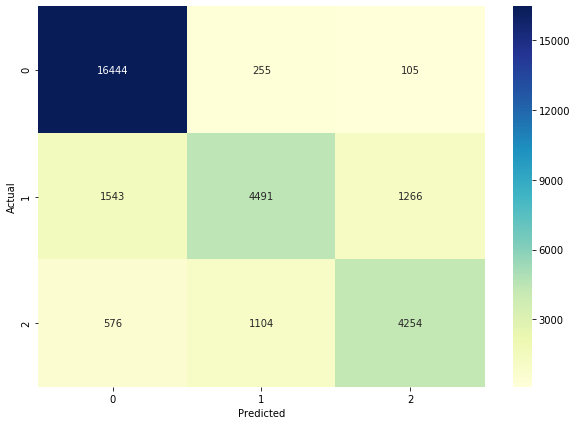

In [50]:
cnf_matrix_test = confusion_matrix (y_test, y_pred_class)

import seaborn as sns

plt.figure(figsize = (10,7))
sns.heatmap(cnf_matrix_test, annot=True, cmap="YlGnBu", fmt='g')
plt.xlabel('Predicted')
plt.ylabel('Actual')

### 7. Troubleshoot

In [51]:
X_test_df = pd.DataFrame(X_test)
X_test_df.reset_index(inplace=True, drop=True)

y_test_df = pd.DataFrame(y_test)
y_test_df.reset_index(inplace=True, drop=True)

In [52]:
y_pred_prob = model.predict_proba(X_test_dtm)
y_pred_class = model.predict(X_test_dtm)

In [53]:
y_pred_prob_df = pd.DataFrame(y_pred_prob)
y_pred_prob_df.columns = ['0-prob', '1-prob', '2-prob']

y_pred_class_df = pd.DataFrame(y_pred_class)
y_pred_class_df.columns = ['predicted']

In [54]:
results_df = X_test_df.join(y_test_df).join(y_pred_class_df).join(y_pred_prob_df)

In [55]:
results_review_df = results_df[(results_df['0-prob'] < 0.6) & (results_df['1-prob'] < 0.6) & (results_df['2-prob'] < 0.6)]
results_review_df.shape

(3324, 6)

In [60]:
pd.set_option('display.max_colwidth', 1000)

In [61]:
results_review_df.head(10)

Violations  \
12                                                                                                                                                                                                                                                                                                                                                                                                              NO VALID CITY OF CHICAGO FOOD SERVICE MANAGER CERTIFICATE POSTED AND NO VALID PROOF OF ENROLLMENT AVAILABLE AT THIS TIME  SERIOUS CITATION ISSUED     MUST SEAL SMALL OPENING ALONG THE BOTTOM OF THE REAR EXIT DOOR IN THE SOUTH CLASSROOM    MUST DETAIL CLEAN THE LOWER SECTIONS OF THE STUDENT STORAGE CUBBIES IN THE MIDDLE CLASSROOM     MUST REPAIR THE BROKEN COLD WATER FAUCET AT THE WASHBOWL IN THE MIDDLE CLASSROOM  MUST REPAIR VENTILATION ABOVE STOVE IN KITCHEN     MUST REMOVE CLUTTER FROM THE HALLWAY STORAGE CLOSET AND THE NORTH CLASSROOM TEACHERS CLOSET  MUST STORE ALL ITEMS  INCHES OFF THE FLOOR    
22     THE FOLLOWING PREVIOUS MINOR VIOLATIONS NOTED ON REPORT  STILL NOT CORRECTED  CLEAN THE FOLLOWING INTERIOR CABINETS OF DEEP FRYERS  OVEN EXPOSED WASHBOWL IN EMPLOYEE WASHROOM INTERIORS  EXTERIORS OF COOLERS  FREEZERS EXTERIORS OF ALL COOKING EQUIPMENT PREP TABLES STORAGE SHELVES HOOD  FILTERS AND ALL OTHER UNCLEAN SURFACES THROUGHOUT  REPLACE OR REPAIR ALL BROKEN FLOOR TILES THROUGHOUT DETAIL CLEAN FLOOR THROUGHOUT KITCHEN ALONG ALL WALL BASES AND IN CORNERS  CLEAN AND PAINT WALLS IN KITCHEN AND IN REAR STORAGE AREA REPLACE ALL CEILING TILES THAT ARE NO LONGER CLEANABLE CITATION ISSUED SERIOUS FOR NON COMPLIANCE WITH EXISTING VIOLATION    MUST REFRAIN FROM USING PLASTIC GROCERY BAGS TO STORE UNWRAPPED FOODS IN COOLERS  FREEZERS AND FROM USING BOXES TO DRAIN EXCESS OIL FROM COOKED FOODS PRIOR TO SERVING TO CUSTOMERS    CLEAN AND PAINT WALLS IN BOTH WASHROOMS IN DINING AREA CLEAN ALL DUSTY CEILING VENTS THROUGHOUT    REPLACE MISSING LIGHT IN REACHIN COOLER BY RICE COOKER IN FOOD PR...   
26     OBSERVED THE FOLLOWING FOODS STORED AT IMPROPER TEMPERATURE IN PREP COOLER SEAFOOD SALAD F CRABMEAT F COOKED FISH F CREAM CHEESE F INSTRUCTED MANAGER TO DISCARD APPROXIMATELY LBS AND  OF FOOD ALL COLD TCS FOOD MUST MAINTAIN F OR BELOW DURING STORAGE PREPARATION DISPLAY AND SERVICE PRIORITY CITATION ISSUED     OBSERVED REFRIGERATED READY TO EAT SLICED CANTALOUPE SEAFOOD SALAD ETC NOT DATED IN WALKIN COOLER ALL REFRIGERATED READY TO EAT TCS FOOD HELD MORE THAN  HOURS SHALL BE CLEARLY MARKED WITH DATE BY WHICH FOOD IS TO BE SOLD CONSUMED OR DISCARDED WITH A MAXIMUM OF  DAYS PRIORITY FOUNDATION CITATION ISSUED     OBSERVED PREP COOLER NOT MAINTAINING PROPER TEMPERATURE F INSTRUCTED MANAGER TO REPAIR AND MAINTAIN COOLER AT F OR BELOW PREP COOLER IS TAGGED HELD FOR INSPECTION AND MUST NOT BE USED UNTIL REINSPECTED BY CHICAGO DEPARTMENT OF HEALTH PRIORITY CITATION ISSUED     OBSERVED SOME BULK CONTAINERS NOT LABELED IN STORAGE AREA INSTRUCTED MANAGER TO LABEL ALL BULK CONTAINERS WITH CO...   
46                                                                                                                                                                                                                                                                  NOTED EMPLOYEES PREPPING SANDWICHES MOVING FROM PREP TABLE TO REFRIGERATION UNIT AT THE REAR AND TO THE CASH REGISTRY WHILE CHANGING GLOVES DID NOT OBSERVE EMPLOYEES WASHING HANDS IN BETWEEN INSTRUCTED TO ALWAYS WASH HANDS WHEN CHANGING GLOVES     CITATION ISSUED FOR CRITICAL VIOLATION A    NOTED ICE ACCUMULATING ON TOP OF BOXES INSIDE WALK IN FREEZER FROM THE CONDENSING UNIT INSTRUCTED TO CLEAN AND MAINTAIN THE CONDENSATION UNITALSO NOTED PIPE UNDERNEATH THE ONE SINK DETACHED INTRUCTED TO INSTALL    INSTRUCTED TO CLEAN INSIDE OF LOWER ICE MACHINE WITH SLIGHT DISCOLORATIONCLEAN AROUND EXPOSED HAND WASH SINK AT THE FRONT WITH MOLD AROUND SILICONE LINING    INSTRUCTED TO CLEAN FLOOR DRAINS AT TH

# Summary
I decided to perform a multi-class classification analysis.  I narrowed my dataset to pass, fail, or pass w/ conditions due to the sufficiency of data. It appears the logistic regression had the best performance of the three models I demonstrated above. The original logisitc regression actually performed better than the one I attempted to optimize. It had a test accuracy of 92%.  The model showed slight signs of overfitting as train accuracy was 96%. Precision and recall for test were 92% for each. Precision was 96% for class 0 (pass), 87% for class 1 (fail) and 86% for class 2 (pass w/ conditions). Furthermore we know f-1 scores are the weighted averaged of precision and recall. F1 scores of 98%, 86%, and 85%, for the same classes listed previously. The model clearly is able to accuractely identify pass recommendations but struggles a little more with fail and pass with conditions, which makes sense intuitively. the F1 scores show slightly more signs of overfitting so I would attempt to adjust that in my parameter tuning. This is out of scope for this analysis, but perhaps I would do some sort of grid search or random search to approximate better parameter values.
* **Pre-processing** For text pre-processing, I decided that we needed to remove stopwords for this analysis. They are noise and do not contribute to the signal of the prediction. I also removed all the digits as again I believe they were more of a distraction. Also, within CountVectorizer, I included parameters to lowercase all words an
* **Train/Test Split** I noticed a considerable class imbalance in the dataset between the three values. I made sure to stratify my sampling in train test split to ensure the train samples and test samples resembled the population of the dataset. Another thing I considered doing but did not as it was out of scope for this analysis was training my model on an equal split data using an under-sampling or oversampling approach. This would give the model a fair chance to fully train each class equally as opposed to seeing more data of the dominate class.


<a id='end'> </a>

# Scratch

In [58]:
df_clean[df_clean['Inspection ID']==2313093]

Inspection ID                      DBA Name  \
35711        2313093  The Indian Garden Restaurant   

                           AKA Name  License # Facility Type           Risk  \
35711  The Indian Garden Restaurant  1646652.0    Restaurant  Risk 1 (High)   

                 Address     City State      Zip Inspection Date  \
35711  247 E ONTARIO ST   CHICAGO    IL  60611.0      09/30/2019   

      Inspection Type Results  \
35711         Canvass    Fail   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                        Violations  \
35711  38. INSECTS, RODENTS, & ANIMALS NOT PRESENT - Comments: FOUND 5 LIVE COCKROACHES BEHIND FOOD STORAGE SHELVES AND MOP CLOSET, INSTRUCTED TO ELIMINATE INSECTS ACTIVITY IN ALL AFFECTED AREAS, PEST CONTROL SERVICE RECOMMENDED. PRIORITY FOUNDATION VIOLATION 7-38-020(A) | 43. IN-USE UTENSILS: PROPERLY STORED - Comments: KNIVES WEDGED BETWEEN 3-COMP SINK AND TABLE, INSTRUCTED TO KEEP IN A CLEAN SURFACE. | 55. PHYSICAL FACILITIES INSTALLED, MAINTAINED & CLEAN - Comments: CRACKS AND CREVICES NOTED THROUGH OUT KITCHEN AND DRY STORAGE ROOM. INSTRUCTED TO SEAL.   

        Latitude  Longitude                                Location  
35711  41.893272 -87.621469  (-87.62146879561675, 41.8932723034826)